In [26]:
from typing import final

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
# Load sales data
sales_data = pd.read_excel('datas.xlsx')
print(sales_data.head())

  order_date      city  unit  unit_price  total_price  customer_order_number  \
0 2024-01-01   Kocaeli     1       62.00         62.0                      1   
1 2024-01-01  İstanbul     1      135.00        135.0                      1   
2 2024-01-01     Kilis     4       33.75        135.0                      1   
3 2024-01-01     Kilis     1       36.00         36.0                      1   
4 2024-01-01  İstanbul     1       63.00         63.0                      2   

   age      sex  
0  NaN  unknown  
1  NaN  unknown  
2  NaN  unknown  
3  NaN  unknown  
4  NaN  unknown  


In [7]:
# Load inflation data
total_sales_inflation_data = pd.read_excel('total_sales_inflation.xlsx')
print(total_sales_inflation_data.head())

   month  total_sales  inflation_rate
0      1      2135379           49.38
1      2      2158681           51.97
2      3      2493503           61.78
3      4      2252183           71.60
4      5      2595595           75.45


In [8]:
import pandas as pd

# Satış verilerindeki order_date sütununu yıl ve ay olarak ayırma
sales_data['order_date'] = pd.to_datetime(sales_data['order_date'])
sales_data['year'] = sales_data['order_date'].dt.year
sales_data['month'] = sales_data['order_date'].dt.month

# Aylık toplam satılan birim (unit), ortalama birim fiyatı (unit_price), toplam satış ve sipariş sayısı hesaplama
monthly_totals = sales_data.groupby(['year', 'month']).agg({
    'unit': 'sum',  # Toplam satılan birim sayısı
    'unit_price': 'mean',  # Ortalama birim fiyatı
    'total_price': 'sum',  # Aylık toplam satış tutarı
    'order_date': 'count'  # Aylık toplam sipariş sayısı (kaç sipariş alındı)
}).reset_index()

# 'order_date' sütununu yeniden adlandırarak 'total_orders' olarak ekliyoruz
monthly_totals.rename(columns={'order_date': 'total_orders'}, inplace=True)

# Enflasyon verisiyle birleştirme (ay bazında)
merged_data = pd.merge(monthly_totals, total_sales_inflation_data, on='month')

# Gerekli sütunları seçme: month, unit, unit_price, total_price, inflation_rate, total_orders
final_data = merged_data[['month', 'unit', 'unit_price', 'total_price', 'inflation_rate', 'total_orders']].copy()

# 1. Aylık Ortalama Sipariş Başına Satılan Birim (unit_per_order)
final_data.loc[:, 'unit_per_order'] = final_data['unit'] / final_data['total_orders']

# 5. Aylık Satış Büyüme Oranı (sales_growth)
# final_data.loc[:, 'sales_growth'] = final_data['total_price'].pct_change() * 100

# Sütun isimlerini daha açıklayıcı hale getirme
final_data.columns = ['month', 'unit', 'unit_price', 'total_sales', 'inflation_rate', 'total_orders', 'unit_per_order']

# Sonuçları yazdırma
print(final_data)


   month   unit  unit_price  total_sales  inflation_rate  total_orders  \
0      1  34697   66.918457   2135379.51           49.38         22652   
1      2  29974   76.413234   2158681.92           51.97         20002   
2      3  34295   78.751181   2493503.42           61.78         22747   
3      4  32692   78.716175   2252183.53           71.60         18900   
4      5  42824   69.836219   2595595.95           75.45         24340   
5      6  37548   67.042899   2169907.92           69.80         20676   
6      7  37528   83.271076   2409347.71           68.50         20175   
7      8  30205  105.253619   2223324.68           67.07         14837   
8      9  30079   78.809952   1873008.03           64.86         14944   

   unit_per_order  
0        1.531741  
1        1.498550  
2        1.507671  
3        1.729735  
4        1.759408  
5        1.816019  
6        1.860124  
7        2.035789  
8        2.012781  


In [19]:
# Özellikler (X) ve hedef değişkeni (y) ayırma
X = final_data[['month', 'unit', 'unit_price', 'inflation_rate', 'total_orders', 'unit_per_order']]
y = final_data['total_sales']

In [20]:
# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# XGBoost modelini oluşturma
model = XGBRegressor()

# Modeli eğitme
model.fit(X_train, y_train)

# Tahminleri yapma
y_pred = model.predict(X_test)

In [28]:
# Model performansını değerlendirme (RMSE ve R² kullanıyoruz)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

Root Mean Squared Error (RMSE): 12468.216550720086
R² Score: 0.8511911080993596


C:\Users\berka\ss\pythonProject\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
# Ortalama toplam satış değeri
average_total_sales = final_data['total_sales'].mean()

# RMSE ve Yüzdesel RMSE hesaplama
rmse_value = 12468.216550720086  # Modelden elde edilen RMSE
percentage_rmse = (rmse_value / average_total_sales) * 100

print(f'Ortalama Toplam Satış: {average_total_sales}')
print(f'Yüzdesel RMSE: {percentage_rmse:.2f}%')


Ortalama Toplam Satış: 2256770.296666667
Yüzdesel RMSE: 0.55%


In [31]:
import pandas as pd

# Aylık tahminleri ve gerçek değerleri saklamak için bir DataFrame hazırlama
monthly_results = pd.DataFrame({'month': range(1, 10)})

# Tahminler ve gerçek değerler için listeler oluşturma
predictions = []
actuals = []

# Aylık veriler üzerinde döngü
for month in range(1, 10):
    # Belirli bir ay için verileri filtreleme
    month_data = final_data[final_data['month'] == month]
    
    # Ay verilerinin boş olup olmadığını kontrol etme
    if month_data.empty:
        print(f"No data for month: {month}")
        continue

    # Ay için özellikleri hazırlama (X değerleri)
    X_month = month_data[['month', 'unit', 'unit_price', 'inflation_rate', 'total_orders', 'unit_per_order']]

    # Ay için tahminler yapma
    month_pred = model.predict(X_month)

    # Tahminleri ve gerçek toplam satışları listeye ekleme
    predictions.append(month_pred.sum())  # Aylık tahmin edilen toplam satış
    actuals.append(month_data['total_sales'].sum())  # Aylık gerçek toplam satış

# Tahminleri ve gerçekleri DataFrame'e ekleme
monthly_results['predicted_total'] = predictions
monthly_results['actual_total'] = actuals

# Aylık sonuçları içeren DataFrame'i yazdırma
print(monthly_results)


   month  predicted_total  actual_total
0      1       2135379.75    2135379.51
1      2       2175344.00    2158681.92
2      3       2493503.25    2493503.42
3      4       2252183.75    2252183.53
4      5       2595595.25    2595595.95
5      6       2169908.25    2169907.92
6      7       2409347.50    2409347.71
7      8       2229094.25    2223324.68
8      9       1873008.25    1873008.03


In [14]:
# MAPE (Mean Absolute Percentage Error) hesaplama
def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# MAE (Mean Absolute Error) hesaplama
def calculate_mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

# Gerçek ve tahmin edilen değerler
actual_values = monthly_results['actual_total']
predicted_values = monthly_results['predicted_total']

# Hata oranlarını hesaplama
mape = calculate_mape(actual_values, predicted_values)
mae = calculate_mae(actual_values, predicted_values)

# Sonuçları yazdırma
print(f'MAPE: {mape:.2f}%')
print(f'MAE: {mae:.2f}')

MAPE: 0.11%
MAE: 2492.64


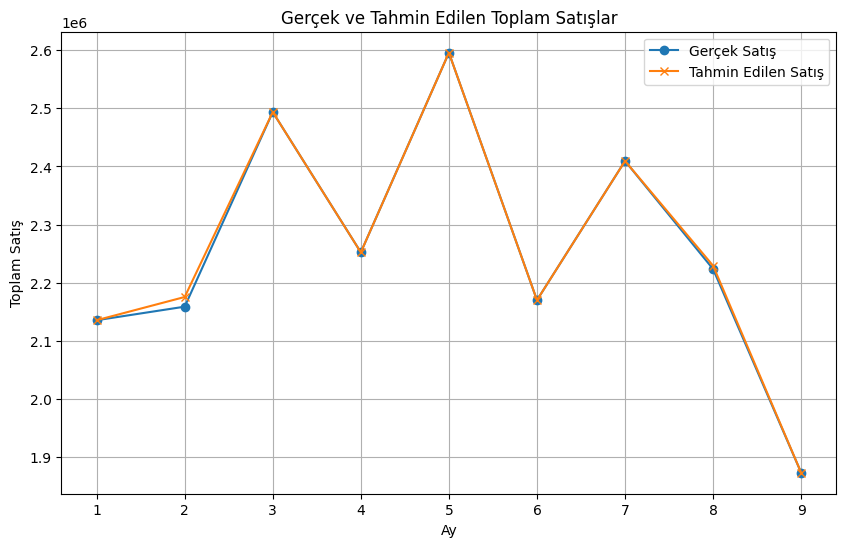

In [15]:
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri çizme
plt.figure(figsize=(10, 6))
plt.plot(monthly_results['month'], monthly_results['actual_total'], label='Gerçek Satış', marker='o')
plt.plot(monthly_results['month'], monthly_results['predicted_total'], label='Tahmin Edilen Satış', marker='x')

# Grafik başlıkları ve etiketleri
plt.title('Gerçek ve Tahmin Edilen Toplam Satışlar')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.legend()

# Grafik gösterimi
plt.grid(True)
plt.show()

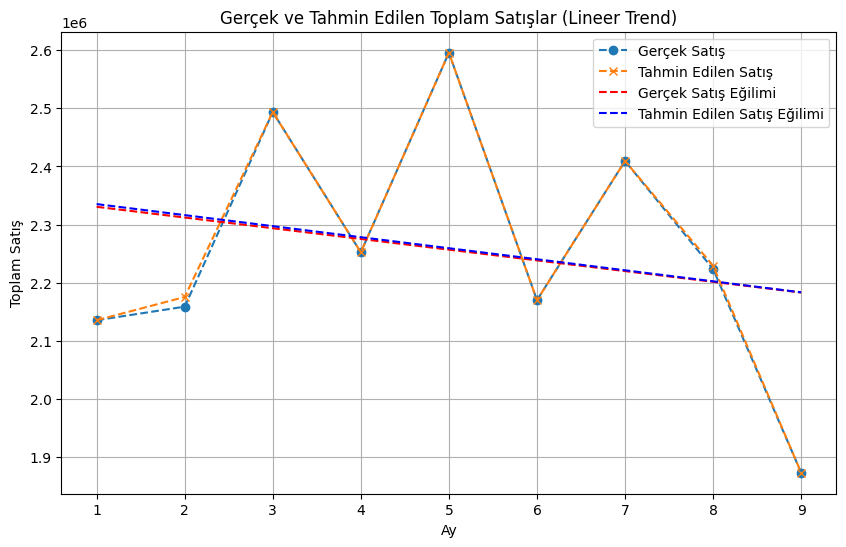

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Gerçek ve tahmin edilen değerleri çizme
plt.figure(figsize=(10, 6))
plt.plot(monthly_results['month'], monthly_results['actual_total'], label='Gerçek Satış', marker='o', linestyle='--')
plt.plot(monthly_results['month'], monthly_results['predicted_total'], label='Tahmin Edilen Satış', marker='x', linestyle='--')

# Gerçek ve tahmin edilen değerlerin ortalama eğilim çizgisini (lineer trend) ekleme
z_actual = np.polyfit(monthly_results['month'], monthly_results['actual_total'], 1)  # Doğru fit (1. derece polinom)
p_actual = np.poly1d(z_actual)
plt.plot(monthly_results['month'], p_actual(monthly_results['month']), "r--", label='Gerçek Satış Eğilimi')

z_predicted = np.polyfit(monthly_results['month'], monthly_results['predicted_total'], 1)
p_predicted = np.poly1d(z_predicted)
plt.plot(monthly_results['month'], p_predicted(monthly_results['month']), "b--", label='Tahmin Edilen Satış Eğilimi')

# Grafik başlıkları ve etiketler
plt.title('Gerçek ve Tahmin Edilen Toplam Satışlar (Lineer Trend)')
plt.xlabel('Ay')
plt.ylabel('Toplam Satış')
plt.legend()

# Grafik gösterimi
plt.grid(True)
plt.show()


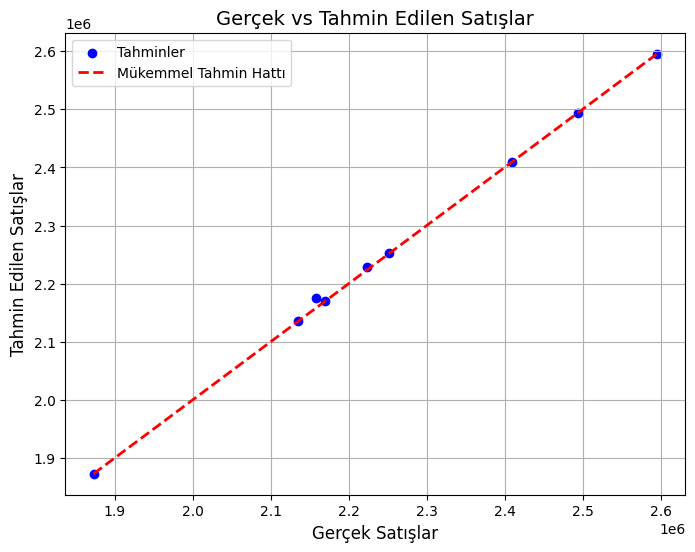

In [19]:
# Scatter plot (gerçek ve tahmin edilen değerler)
plt.figure(figsize=(8, 6))
plt.scatter(monthly_results['actual_total'], monthly_results['predicted_total'], color='blue', label='Tahminler')
plt.plot([monthly_results['actual_total'].min(), monthly_results['actual_total'].max()],
         [monthly_results['actual_total'].min(), monthly_results['actual_total'].max()],
         'r--', lw=2, label='Mükemmel Tahmin Hattı')

# Grafik başlıkları ve etiketler
plt.title('Gerçek vs Tahmin Edilen Satışlar', fontsize=14)
plt.xlabel('Gerçek Satışlar', fontsize=12)
plt.ylabel('Tahmin Edilen Satışlar', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


In [35]:
# Geçmiş verilerin ortalamalarını alarak tahmin edilecek değerleri belirleme
avg_unit = final_data['unit'].mean()
avg_unit_price = final_data['unit_price'].mean()
avg_total_orders = final_data['total_orders'].mean()
avg_unit_per_order = final_data['unit_per_order'].mean()

# 10. ay için tahmin yapılacak veriler
month_10_data = {
    'month': [10],  # 10. ay
    'unit': [33888.81],  # Ortalama satılan birim
    'unit_price': [89.29],  # Ortalama birim fiyat
    'inflation_rate': [74.395],  # Verilen enflasyon oranı
    'total_orders': [15777.97],  # Ortalama sipariş sayısı
    'unit_per_order': [2.11]  # Ortalama sipariş başına satılan birim
}

# Tahmin yapmak için verileri DataFrame'e dönüştürme
month_10_df = pd.DataFrame(month_10_data)

# 10. ay için tahmin
month_10_pred = model.predict(month_10_df)

# 10. ay tahmin sonucunu yazdırma
print(f'10. Ay Tahmin Edilen Toplam Satış: {month_10_pred[0]:.2f}')


10. Ay Tahmin Edilen Toplam Satış: 2071478.75
